In [3]:
import sys
sys.path.append('../.')
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
import patsy
import pdb

from utils import make_confusion_matrix,load_heterogeneous_data,split_data
from pathlib import Path
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, average_precision_score

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit, Logit

seeds = [3707, 11730, 22229, 42732, 57446]

def create_mat(dicc, path, figsize=(4,4.3)):
    conf_mat = [[0, 0, 0], [0,0,0], [0,0,0]]
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[0])):
            conf_mat[i][j] = sum([co['confusion_matrix'][i][j] for co in dicc])
    sc = {'Balanced Accuracy': np.mean([x['balanced_accuracy'] for x in dicc])}
    utils.make_confusion_matrix(np.array(conf_mat), categories=['CN', 'MCI', 'AD'], cbar=False, sum_stats=True, figsize=figsize, file_path=path, scores=sc)
    return np.array(conf_mat)

def create_mat_binary(dicc, path, figsize=(3,3.5)):
    conf_mat = [[0, 0], [0,0]]
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[0])):
            conf_mat[i][j] = sum([co['confusion_matrix'][i][j] for co in dicc])
    sc = {'Balanced Accuracy': np.mean([x['balanced_accuracy'] for x in dicc]), \
         'ROC AUC': np.mean([x['roc_auc'] for x in dicc]), \
         'PR AUC': np.mean([x['average_precision'] for x in dicc])}
    utils.make_confusion_matrix(np.array(conf_mat), categories=['CN', 'AD'], cbar=False, sum_stats=True, figsize=figsize, file_path=path, scores=sc)
    return np.array(conf_mat)


If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



# 3 Classes

In [181]:
adni = load_heterogeneous_data(
    # PATH RERMOVED FOR PRIVACY,
    # PATH RERMOVED FOR PRIVACY,
    hippocampus='Left-Hippocampus', masking='vol_with_bg', visit_codes=True, label_coding={"CN": 0, "MCI": 1, "Dementia": 2}, filter_unreliable_data=True)

Optimization terminated successfully.
         Current function value: 0.875177
         Iterations: 420
         Function evaluations: 425
         Gradient evaluations: 425
Optimization terminated successfully.
         Current function value: 0.888984
         Iterations: 388
         Function evaluations: 393
         Gradient evaluations: 393
Optimization terminated successfully.
         Current function value: 0.876593
         Iterations: 419
         Function evaluations: 424
         Gradient evaluations: 424
Optimization terminated successfully.
         Current function value: 0.898534
         Iterations: 443
         Function evaluations: 449
         Gradient evaluations: 449
Optimization terminated successfully.
         Current function value: 0.883506
         Iterations: 436
         Function evaluations: 439
         Gradient evaluations: 439
BAcc: 52.64$\pm$1.67
[51.71, 51.74, 51.96, 55.97, 51.84]


array([[425, 307,  22],
       [214, 575, 132],
       [ 25, 204, 146]])

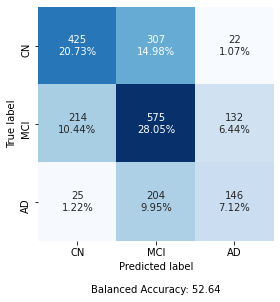

In [182]:
results_adni = []

for seed in seeds:
    data = split_data(adni[0], groups=adni[1], visit_codes=adni[2], test_size=0.2, seed=seed)
    out = 0
    # train
    d = data['train']
    labels = np.array([d[i][2] for i in range(len(d))])
    ex = np.array([np.array(item[1], dtype=np.float) for item in d])
    model = MNLogit(endog=labels, exog=sm.add_constant(ex))
    res = model.fit(maxiter=1000, method='bfgs', skip_hessian=True)

    # test
    d = data['test']
    labels = np.array([d[i][2] for i in range(len(d))])
    ex = np.array([np.array(item[1], dtype=np.float) for item in d])
    out = res.predict(sm.add_constant(ex))
    out = np.argmax(out, axis=1)
    
    # calc score and append
    results_adni.append(
        {'balanced_accuracy': balanced_accuracy_score(y_true=labels, y_pred=out),
        'confusion_matrix': confusion_matrix(y_true=labels, y_pred=out)}
    )
    
    
print(f'BAcc: ' + utils.round_val(np.mean([item['balanced_accuracy'] for item in results_adni]))+ '$\pm$'+  utils.round_val(np.std([item['balanced_accuracy'] for item in results_adni])))
print([float(utils.round_val(x['balanced_accuracy'])) for x in results_adni])
create_mat(results_adni, path='../figs/3LogRegADNI.pdf', figsize=(4,4.3))


# 2 Classes

In [4]:
adni = load_heterogeneous_data(
    # PATH RERMOVED FOR PRIVACY,
    # PATH RERMOVED FOR PRIVACY,
    hippocampus='Left-Hippocampus', masking='vol_with_bg', visit_codes=True, label_coding={"CN": 0, "Dementia": 1}, filter_unreliable_data=False)

Optimization terminated successfully.
         Current function value: 0.403434
         Iterations: 229
         Function evaluations: 234
         Gradient evaluations: 234
Optimization terminated successfully.
         Current function value: 0.404989
         Iterations: 284
         Function evaluations: 288
         Gradient evaluations: 288
Optimization terminated successfully.
         Current function value: 0.430845
         Iterations: 206
         Function evaluations: 210
         Gradient evaluations: 210
Optimization terminated successfully.
         Current function value: 0.430702
         Iterations: 243
         Function evaluations: 247
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: 0.436821
         Iterations: 222
         Function evaluations: 226
         Gradient evaluations: 226
BAcc: 77.99$\pm$1.50
[76.3, 77.62, 80.8, 77.86, 77.37]


array([[734, 105],
       [215, 466]])

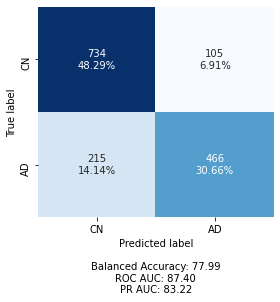

In [13]:
results_adni = []

for seed in seeds:
    data = split_data(adni[0], groups=adni[1], visit_codes=adni[2], test_size=0.2, seed=seed)
    out = 0
    # train
    d = data['train']
    labels = np.array([d[i][2] for i in range(len(d))])
    ex = np.array([np.array(item[1], dtype=np.float) for item in d])
    model = Logit(endog=labels, exog=sm.add_constant(ex))
    res = model.fit(maxiter=1000, method='bfgs', skip_hessian=True)

    # test
    d = data['test']
    labels = np.array([d[i][2] for i in range(len(d))])
    ex = np.array([np.array(item[1], dtype=np.float) for item in d])
    out = res.predict(sm.add_constant(ex))
    
    out_class = (out > 0.5).astype(np.int)
    # calc score and append
    results_adni.append(
        {'balanced_accuracy': balanced_accuracy_score(y_true=labels, y_pred=out_class),
        'confusion_matrix': confusion_matrix(y_true=labels, y_pred=out_class),
        'roc_auc': roc_auc_score(y_true=labels, y_score=out),
        'average_precision': average_precision_score(y_true=labels, y_score=out)}
    )
    
    # save weights
    np.savetxt('weights_log_reg_binary_' + str(seed) + '.csv', res.params, delimiter=",")
    
print(f'BAcc: ' + utils.round_val(np.mean([item['balanced_accuracy'] for item in results_adni]))+ '$\pm$'+  utils.round_val(np.std([item['balanced_accuracy'] for item in results_adni])))
print([float(utils.round_val(x['balanced_accuracy'])) for x in results_adni])
create_mat_binary(results_adni, path='../figs/2LogRegADNI.pdf', figsize=(4,4.3))
